In [1]:
# ipynb形式のライブラリのインポート
%run ./lib/lib.ipynb

# 生データの入ったCSVファイルの保持されたディレクトリ名を格納している変数
csvDirPath = "./csv_files/"
benchmarkNames = ["cg", "ep", "ft", "is", "lu", "mg"]

DEBUG:__main__:hello


In [2]:
# ipynb形式のライブラリノートを.py形式に変更したものをインポート
import lib
import lib.lab_lib
from lib.lab_lib import *

DEBUG:lib.lab_lib:hello


# 2022年3月10日～

# 組み合わせも出るとベースモデルで同じMAPEになってしまう理由の調査

## 調査メモ

* processes リストが 1-128 の場合は上記の問題が発生するが、1-256 の場合は発生しない

In [3]:
benchmark_name = "cg"

classes = ["A", "B", "C", "D", "E", "F"]
processes = [2, 4, 8, 16, 32, 64, 128]

dict_column_names_JP = {
    "functionName": "関数名",
    "modelLin": "線形",
    # "modelIp": "反比例",
    # "modelLog": "対数",
    "modelLinAndIp": "線形＆反比例",
    "modelLinAndLog": "線形＆対数",
    # "modelIpAndLin": "反比例＆線形",
    # "modelIpAndLog": "反比例＆対数",
    # "modelLogAndLin": "対数＆線形",
    # "modelLogAndIp": "対数＆反比例",
    # "modelProcessDividedByProblemSize": "プロセス数を問題サイズで割る"
}

model_names_list_JP = list(dict_column_names_JP.values())
model_names_list_JP.remove("関数名")

model_names_list = list(dict_column_names_JP.keys())
model_names_list.remove("functionName")

date = "2022年3月16日"

# コア数と問題サイズの両方を振る

rawDF = return_rawDF_with_init_param(
    benchmark_name=benchmark_name,
    classes=classes,
    processes=processes,
    csv_dir_path="./csv_files/",
)

rawDF = rawDF[rawDF["functionName"] == "CONJ_GRAD"]

exp_var = rawDF.columns.tolist()
for element_be_removed in [
    "functionName",
    "functionCallNum",
    "intBenchmarkClass",
    "benchmarkName",
    "benchmarkClass",
]:
    exp_var.remove(element_be_removed)
res_var = ["functionCallNum"]

returned_MAPE_table = return_MAPE_Table_DF_from_rawDF(
    rawDF=rawDF,
    exp_var_list=exp_var,
    res_var_list=res_var,
    model_name_list=model_names_list,
)
df = returned_MAPE_table.rename(columns=dict_column_names_JP)
df = df.set_index("関数名")
df = df.sort_index(axis=0)
df = df.sort_index(axis=1)

df = addLowestMAPEsModelNameColumn(df, version=2, model_name_list=model_names_list_JP)

pd.options.display.precision = 15
print(df)

print(
    df.style.to_latex(
        caption=f"ベンチマークプログラム{benchmark_name.upper()}における各モデルでのMAPE",
        label=f"{date}allModelsMAPEin{benchmark_name.upper()}",
    )
)
pd.options.display.precision = 6

                           線形              線形＆反比例               線形＆対数   最適モデル
関数名                                                                          
CONJ_GRAD  14.443369512637627  14.443369512601715  14.443369512638366  線形＆反比例
\begin{table}
\caption{ベンチマークプログラムCGにおける各モデルでのMAPE}
\label{2022年3月16日allModelsMAPEinCG}
\begin{tabular}{lrrrl}
 & 線形 & 線形＆反比例 & 線形＆対数 & 最適モデル \\
関数名 &  &  &  &  \\
CONJ_GRAD & 14.443370 & 14.443370 & 14.443370 & 線形＆反比例 \\
\end{tabular}
\end{table}



In [4]:
benchmark_name = "cg"

classes = ["A", "B", "C", "D", "E", "F"]
processes = [2, 4, 8, 16, 32, 64, 128, 256]

dict_column_names_JP = {
    "functionName": "関数名",
    "modelLin": "線形",
    "modelIp": "反比例",
    "modelLog": "対数",
    "modelLinAndIp": "線形＆反比例",
    "modelLinAndLog": "線形＆対数",
    "modelIpAndLin": "反比例＆線形",
    "modelIpAndLog": "反比例＆対数",
    "modelLogAndLin": "対数＆線形",
    "modelLogAndIp": "対数＆反比例",
}

model_names_list_JP = list(dict_column_names_JP.values())
model_names_list_JP.remove("関数名")

model_names_list = list(dict_column_names_JP.keys())
model_names_list.remove("functionName")

date = "2022年2月2日"

# コア数と問題サイズの両方を振る

rawDF = return_rawDF_with_init_param(
    benchmark_name=benchmark_name,
    classes=classes,
    processes=processes,
    csv_dir_path="./csv_files/",
)

exp_var = rawDF.columns.tolist()
for element_be_removed in [
    "functionName",
    "functionCallNum",
    "intBenchmarkClass",
    "benchmarkName",
    "benchmarkClass",
]:
    exp_var.remove(element_be_removed)
res_var = ["functionCallNum"]

rawDF_CONJ_GRAD = rawDF[rawDF["functionName"] == "CONJ_GRAD"]
rawDF_CONJ_GRAD

# returned_MAPE_table = return_MAPE_Table_DF_from_rawDF(
#     rawDF=rawDF,
#     exp_var_list=exp_var,
#     res_var_list=res_var,
#     model_name_list=model_names_list,
# )
# df = returned_MAPE_table.rename(columns=dict_column_names_JP)
# df = df.set_index("関数名")
# df = df.sort_index(axis=0)
# df = df.sort_index(axis=1)

# df = addLowestMAPEsModelNameColumn(df, version=2, model_name_list=model_names_list_JP)

# print(
#     df.to_latex(
#         caption=f"ベンチマークプログラム{benchmark_name.upper()}における各モデルでのMAPE",
#         label=f"{date}everyModelsMAPEtableIn{benchmark_name.upper()}",
#     )
# )

,functionName,functionCallNum,benchmarkName,benchmarkClass,process,intBenchmarkClass,na,nonzer,niter,shift
5,CONJ_GRAD,16.0,cg,A,2,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,4,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,8,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,16,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,32,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,64,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,128,1,14000,11,15,20
6,CONJ_GRAD,16.0,cg,A,256,1,14000,11,15,20
2,CONJ_GRAD,31.0,cg,B,2,4,75000,13,75,60
2,CONJ_GRAD,46.0,cg,B,4,4,75000,13,75,60


# （2022年2月23日～2022年3月7日）

## ✅新モデルの実装

# (2022年3月7日～2022年3月9日)

## ✅新モデルを含めたMAPE表の作成

In [5]:
benchmark_name = "cg"

classes = ["A", "B", "C", "D", "E", "F"]
processes = [2, 4, 8, 16, 32, 64, 128, 256]

dict_column_names_JP = {
    "functionName": "関数名",
    "modelLin": "線形",
    "modelIp": "反比例",
    "modelLog": "対数",
    "modelLinAndIp": "線形＆反比例",
    "modelLinAndLog": "線形＆対数",
    "modelIpAndLin": "反比例＆線形",
    "modelIpAndLog": "反比例＆対数",
    "modelLogAndLin": "対数＆線形",
    "modelLogAndIp": "対数＆反比例",
    "modelProcessDividedByProblemSize": "プロセス数を問題サイズで割る"
}

model_names_list_JP = list(dict_column_names_JP.values())
model_names_list_JP.remove("関数名")

model_names_list = list(dict_column_names_JP.keys())
model_names_list.remove("functionName")

date = "2022年3月9日"

# コア数と問題サイズの両方を振る

rawDF = return_rawDF_with_init_param(
    benchmark_name=benchmark_name,
    classes=classes,
    processes=processes,
    csv_dir_path="./csv_files/",
)

exp_var = rawDF.columns.tolist()
for element_be_removed in [
    "functionName",
    "functionCallNum",
    "intBenchmarkClass",
    "benchmarkName",
    "benchmarkClass",
]:
    exp_var.remove(element_be_removed)
res_var = ["functionCallNum"]

print(f"exp_var = {exp_var}")

returned_MAPE_table = return_MAPE_Table_DF_from_rawDF(
    rawDF=rawDF,
    exp_var_list=exp_var,
    res_var_list=res_var,
    model_name_list=model_names_list,
)
df = returned_MAPE_table.rename(columns=dict_column_names_JP)
df = df.set_index("関数名")
df = df.sort_index(axis=0)
df = df.sort_index(axis=1)

df = addLowestMAPEsModelNameColumn(df, version=2, model_name_list=model_names_list_JP)

print(
    df.style.to_latex(
        caption=f"ベンチマークプログラム{benchmark_name.upper()}における各モデルでのMAPE",
        label=f"{date}allModelsMAPEin{benchmark_name.upper()}",
    )
)

exp_var = ['process', 'na', 'nonzer', 'niter', 'shift']


/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estima

\begin{table}
\caption{ベンチマークプログラムCGにおける各モデルでのMAPE}
\label{2022年3月9日allModelsMAPEinCG}
\begin{tabular}{lrrrrrrrrrrl}
 & プロセス数を問題サイズで割る & 反比例 & 反比例＆対数 & 反比例＆線形 & 対数 & 対数＆反比例 & 対数＆線形 & 線形 & 線形＆反比例 & 線形＆対数 & 最適モデル \\
関数名 &  &  &  &  &  &  &  &  &  &  &  \\
.TAU_application & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 線形 \\
ALLOC_SPACE & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 線形 \\
CG & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 線形 \\
CONJ_GRAD & 37.550135 & 13.876670 & 13.732936 & 14.498431 & 14.804389 & 14.717362 & 15.248570 & 13.161174 & 12.412559 & 12.755412 & 線形＆反比例 \\
ICNVRT & 159.614199 & 662.481358 & 2504.274677 & 894.574028 & 2443.699386 & 3811.490854 & 815.789372 & 502.123230 & 6621.011052 & 2283.060136 & プロセス数を問題サイズで割る \\
INITIALIZE_MPI & 0.000000 & 0.000000 & 0.000000 & 0.0000

/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# （2022年2月22日～）【個人作業】

# 回帰木による予測

## TODO

* ✅とりあえずひとつの関数で予測をやってみる
* ✅クラス化
    * ✅テストを書く
    * ✅実装
 

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import tree
from IPython.display import Image
from sklearn.datasets import fetch_california_housing
import pydotplus

def test_Model_BasicTree():
    """回帰木による予測を行うモデル

    「回帰木による予測を実現するためのクラス」のテストを実施する

    Attributes:
        
    Note:
    """

    # テストデータはsklearn付属のものを使用
    california_housing = fetch_california_housing()
    list_exp :list[str] = california_housing.feature_names
    list_res :list[str] = ["target"]
    df_data :pd.DataFrame = pd.DataFrame(california_housing.data, columns=list_exp)
    df_target :pd.DataFrame = pd.DataFrame(california_housing.target, columns=list_res)
    df_california_housing :pd.DataFrame = pd.concat([df_data, df_target],axis=1)
    array_california_housing :np.ndarray = df_california_housing.values
    array_x_california_housing :np.ndarray = array_california_housing[:,0:-1]
    array_y_california_housing :np.ndarray = array_california_housing[:, -1]
    df_california_housing["functionName"] = "functionName"
    # テストデータによるモデルの構築
    reg = DecisionTreeRegressor(max_leaf_nodes=20)
    model :DecisionTreeRegressor = reg.fit(array_x_california_housing, array_y_california_housing)
    # テストデータによる予測
    YHat :np.ndarray = model.predict(array_x_california_housing)
    r2 :float = r2_score(array_y_california_housing, YHat)
    # 構築したモデルによるMAPEの算出
    mape_expect :float = returnMapeScore(array_y_california_housing, YHat)

    # クラスを用いたモデル構築
    objectModel = Model_BasicTree(
        inputDF = df_california_housing,
        explanatoryVariableColumnNames=list_exp,
        responseVariableColumnNames = list_res,
        conditionDictForTest={},
    )
    objectModel.build_model()
    # クラスを用いたMAPEの受け取り
    mape_actually :float = objectModel.returnMAPE()
    assert math.isclose(mape_expect, mape_actually), f"mape_expect({mape_expect}) != mape_actually({mape_actually})"

class Model_BasicTree(ModelBaseForMultipleRegression):
    """回帰木による予測を行うモデル

    回帰木による予測を実現するためのクラス

    Attributes:
        basicTree : モデルのオブジェクト
        dataXForPredict : 説明変数のDF
        dataTForPredict : 目的変数のDF
    Note:
    """
    
    def build_model(self) -> bool:
        """build_model(self)

        inputDFのデータからモデル構築する。

        Args:
            self : none

        Returns: boolean。成功ならTrue,失敗ならFalse
        """
        self.array_dataXForPredict :np.ndarray = self.rawExplanaoryVariable.values
        self.array_dataTForPredict :np.ndarray = self.rawResponseVariable.values

        self.reg = DecisionTreeRegressor(max_leaf_nodes = 20)
        self.model :DecisionTreeRegressor = self.reg.fit(self.array_dataXForPredict, self.array_dataTForPredict)
        return True

    def predict(self, inputDF :pd.DataFrame) -> np.ndarray:
        """predict(self, inputDF)

        inputDFのデータから構築されたモデルを使って予測を行う

        Args:
            self : none
            inputDF (pandas.DataFrame): 構築されたモデルを用いて予測に使うDF

        Returns:
            pandas.DataFrame: 構築されたモデルから予測された値。型に確証なし

        Note:
        """
        
        # モデル構築に用いた説明変数のカラム名と、与えられたDFのカラム名が一致していることを確認
        if self.explanatoryVariableColumnNames != inputDF.columns.to_list():
            warnings.warn(f"self.explanatoryVariableColumnNames != inputDF.columns.to_list(), {self.explanatoryVariableColumnNames} != {inputDF.columns.to_list()}")
            inputDF = inputDF[self.explanatoryVariableColumnNames]
        # .predict()する
        array_forPredicting :np.ndarray = inputDF.values
        return_value :np.ndarray = self.model.predict(array_forPredicting)
        # .predict()で返された値を返す
        return (return_value)

    def returnMAPE(self) -> float:
        """calcMAPE(self)

        モデルの構築に使用されたデータからMAPEを算出する

        Args:
            self : none

        Returns:
            list: モデルの構築に用いたデータから予測された値
            int: 失敗した場合、-1
        
        Note:
        """

        array_real_data :np.ndarray = self.rawResponseVariable.values
        array_predicted_data :np.ndarray = self.predict(self.rawExplanaoryVariable)
        return_num :float = float(returnMapeScore(array_real_data, array_predicted_data))

        return(return_num)

test_Model_BasicTree()

In [7]:
rawDF

,functionName,functionCallNum,benchmarkName,benchmarkClass,process,intBenchmarkClass,na,nonzer,niter,shift
0,.TAU_application,1.0,cg,A,2,1,14000,11,15,20
1,CG,1.0,cg,A,2,1,14000,11,15,20
2,MPI_Finalize(),1.0,cg,A,2,1,14000,11,15,20
3,INITIALIZE_MPI,1.0,cg,A,2,1,14000,11,15,20
4,MPI_Init(),1.0,cg,A,2,1,14000,11,15,20
...,...,...,...,...,...,...,...,...,...,...
17,MPI_Reduce(),1.0,cg,F,256,65536,54000000,26,100,1500
18,SETUP_SUBMATRIX_INFO,1.0,cg,F,256,65536,54000000,26,100,1500
19,MPI_Comm_size(),1.0,cg,F,256,65536,54000000,26,100,1500
20,MPI_Comm_rank(),1.0,cg,F,256,65536,54000000,26,100,1500


In [8]:
rawDF_CONJ_GRAD = rawDF[rawDF["functionName"] == "CONJ_GRAD"]
rawDF_CONJ_GRAD

,functionName,functionCallNum,benchmarkName,benchmarkClass,process,intBenchmarkClass,na,nonzer,niter,shift
5,CONJ_GRAD,16.0,cg,A,2,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,4,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,8,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,16,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,32,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,64,1,14000,11,15,20
5,CONJ_GRAD,16.0,cg,A,128,1,14000,11,15,20
6,CONJ_GRAD,16.0,cg,A,256,1,14000,11,15,20
2,CONJ_GRAD,31.0,cg,B,2,4,75000,13,75,60
2,CONJ_GRAD,46.0,cg,B,4,4,75000,13,75,60


In [9]:
print(f"exp_var = {exp_var}")

print(f"res_var = {res_var}")

print(f"rawDF_CONJ_GRAD.shape = {rawDF_CONJ_GRAD.shape}")

exp_var = ['process', 'na', 'nonzer', 'niter', 'shift']
res_var = ['functionCallNum']
rawDF_CONJ_GRAD.shape = (37, 10)


In [10]:
X = rawDF_CONJ_GRAD.filter(items=exp_var)
Y = rawDF_CONJ_GRAD.filter(items=res_var)

In [11]:


X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.1, random_state=1234
)

# X_train, X_test, Y_train, Y_test

In [12]:
reg = DecisionTreeRegressor(max_leaf_nodes=20)

model = reg.fit(X_train, Y_train)
print(f"model = {model}")

model = DecisionTreeRegressor(max_leaf_nodes=20)


In [13]:


YHat = model.predict(X_test)
r2 = r2_score(Y_test, YHat)
print("R^2 = ", r2)

R^2 =  0.9516129032258065


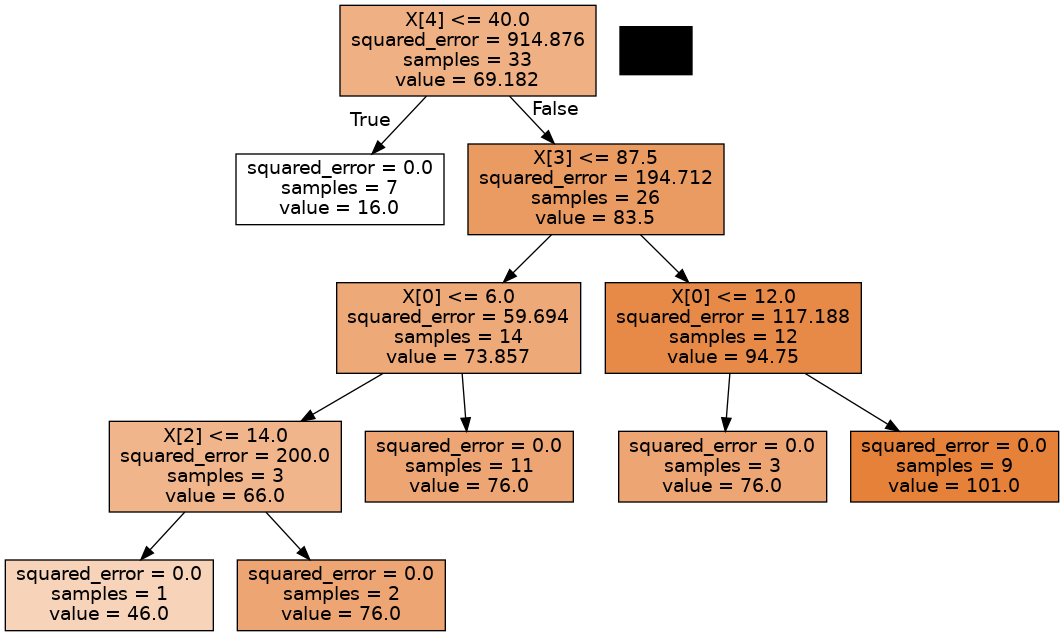

In [14]:


dot_data = tree.export_graphviz(
    model,
    out_file=None,
    # feature_names=rawDF_CONJ_GRAD.feature_names,
    class_names="functionCallNum",
    filled=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())